In [47]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve


In [48]:
df = pd.read_csv("/Users/shivamverma/Downloads/chicken prices.csv")

/var/folders/0h/mz4ht1jx3db5k740465q827h0000gn/T/ipykernel_20898/2716809264.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/shivamverma/Downloads/chicken prices.csv")


In [49]:
df_info = df.info()
df_head = df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988000 entries, 0 to 2987999
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                int64  
 1   banner            object 
 2   fullname          object 
 3   size              object 
 4   edited_at         object 
 5   current_price_ea  float64
 6   city              object 
 7   province          object 
dtypes: float64(1), int64(1), object(6)
memory usage: 182.4+ MB


In [50]:
# Check for missing values
missing_values = df.isnull().sum()

In [51]:
# Check for duplicate records
duplicate_count = df.duplicated().sum()

In [52]:
# Display summary
df_info, df_head, missing_values, duplicate_count

(None,
       id         banner                                           fullname  \
 0  10876  Save-on-Foods  Rossdown Organic Chicken Apple Spice Sausages,...   
 1  10876  Save-on-Foods  Rossdown Organic Chicken Apple Spice Sausages,...   
 2  10876  Save-on-Foods  Rossdown Organic Chicken Apple Spice Sausages,...   
 3  10876  Save-on-Foods  Rossdown Organic Chicken Apple Spice Sausages,...   
 4  10876  Save-on-Foods  Rossdown Organic Chicken Apple Spice Sausages,...   
 
        size                edited_at  current_price_ea      city province  
 0  300 Gram  2020-03-18 23:06:14.046              9.99  Winnipeg       MB  
 1  300 Gram  2020-03-18 23:06:14.046              9.99  Winnipeg       MB  
 2  300 Gram  2020-03-18 23:06:14.046              9.99  Winnipeg       MB  
 3  300 Gram  2020-03-25 23:06:13.364              9.99  Winnipeg       MB  
 4  300 Gram  2020-03-25 23:06:13.364              9.99  Winnipeg       MB  ,
 id                       0
 banner                   

### Observations from the Dataset

Missing Values: The size column has 381,013 missing values. That’s significant and needs to be addressed.

Potential Duplicates: Multiple records have identical values (same id, banner, fullname, size, city, province, and current_price_ea), which suggests some duplicate data.

Date Format Issues: The edited_at column appears to have timestamps, so we may need to convert it to a proper datetime format for time-series analysis.

Unit Standardization: The size column uses grams (e.g., "300 Gram"), but if there are other units (e.g., ounces, kilograms), we may need to standardize them

### Cleaning and Processing Plan


Handle Missing Values in the size Column
This approach:

Uses forward-fill (ffill) and backward-fill (bfill) within each id group to replace missing sizes.
Drops rows where the size is still missing.

In [53]:
# Fill missing sizes by mapping known values from the same product ID
df['size'] = df.groupby('id')['size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# Check how many values are still missing
print(df['size'].isnull().sum())

# Optionally drop remaining rows if the missing percentage is too high
df = df.dropna(subset=['size'])

/var/folders/0h/mz4ht1jx3db5k740465q827h0000gn/T/ipykernel_20898/3545052195.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['size'] = df.groupby('id')['size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/0h/mz4ht1jx3db5k740465q827h0000gn/T/ipykernel_20898/3545052195.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['size'] = df.groupby('id')['size'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


381013


In [54]:
# Remove exact duplicates
df = df.drop_duplicates()

# Check the new shape of the dataset
print("New dataset size after removing duplicates:", df.shape)


New dataset size after removing duplicates: (1820660, 8)


#### Convert edited_at to Proper Date Format
Since edited_at contains timestamps, we should convert it to a datetime column for time-series analysis.

In [55]:
# Convert 'edited_at' to datetime format
df['edited_at'] = pd.to_datetime(df['edited_at'])

# Extract year and month for easier grouping
df['year_month'] = df['edited_at'].dt.to_period('M')

# Check the updated column
print(df[['edited_at', 'year_month']].head())


                 edited_at year_month
0  2020-03-18 23:06:14.046    2020-03
3  2020-03-25 23:06:13.364    2020-03
6  2020-04-01 23:06:13.449    2020-04
9  2020-04-16 04:51:03.249    2020-04
15 2020-04-22 23:06:04.867    2020-04


### Standardize Product Size

size column contains different units (grams, ounces, kilograms), we need to convert everything to grams

In [56]:
# Function to convert sizes to grams
def convert_to_grams(size_str):
    size_str = str(size_str).lower()  # Convert to lowercase for uniformity
    try:
        if 'kg' in size_str:
            return float(size_str.replace('kg', '').strip()) * 1000  # Convert kg to grams
        elif 'oz' in size_str:
            return float(size_str.replace('oz', '').strip()) * 28.3495  # Convert oz to grams
        elif 'g' in size_str:
            return float(size_str.replace('g', '').strip())  # Keep grams as is
        else:
            return np.nan  # If unit is not recognized, return NaN
    except Exception as e:
        return np.nan


In [57]:
import numpy as np

In [58]:

# Apply conversion function
df['size_in_grams'] = df['size'].apply(convert_to_grams)


In [59]:
# Check if any sizes failed to convert
print(df['size_in_grams'].isnull().sum())

1494689


In [60]:
# Drop rows with unrecognized sizes
df = df.dropna(subset=['size_in_grams'])

### Now, price per unit comparison is fair.



In [61]:
# Calculate price per gram
df['price_per_gram'] = df['current_price_ea'] / df['size_in_grams']

# Check for extreme values
print(df[['current_price_ea', 'size_in_grams', 'price_per_gram']].describe())

# Drop outliers if necessary (e.g., prices that are unreasonably high/low)
df = df[(df['price_per_gram'] > 0.001) & (df['price_per_gram'] < 1)]


       current_price_ea  size_in_grams  price_per_gram
count     325971.000000  325971.000000   325971.000000
mean           7.932885     781.189102        0.085524
std            1.633580     534.620814        0.761183
min            0.000000       0.870000        0.000000
25%            7.000000     454.000000        0.007338
50%            8.000000     454.000000        0.015374
75%            9.000000     954.000000        0.017621
max           11.000000    1816.000000       11.467890


### Missing Values Outcome:
381,013 missing values in size column were present before imputation.

### Duplicate Removal
New Dataset Size After Removing Duplicates:
(1,820,660 rows, 8 columns)

### Date Formatting & Aggregation
✅ Date Transformation Results:
The edited_at column was successfully converted to datetime.
The year_month column now allows us to group data by months (e.g., 2020-03, 2020-04).

In [62]:
# Remove zero or near-zero price per gram (possible data errors)
df = df[df['price_per_gram'] > 0.001]

# Remove extreme outliers (chicken shouldn't be $11 per gram!)
df = df[df['price_per_gram'] < 1.0]

In [63]:
# Check new statistics
print(df[['current_price_ea', 'size_in_grams', 'price_per_gram']].describe())

       current_price_ea  size_in_grams  price_per_gram
count     319235.000000  319235.000000   319235.000000
mean           8.035614     792.272934        0.013155
std            1.399035     533.706234        0.005135
min            2.870000     450.000000        0.004000
25%            7.000000     454.000000        0.007338
50%            8.000000     454.000000        0.015396
75%            9.000000     954.000000        0.017621
max           11.000000    1816.000000        0.024229


In [64]:
# ✅ Step 1: Convert `edited_at` to Date Format (if not already done)
df['edited_at'] = pd.to_datetime(df['edited_at'])


In [65]:
# ✅ Step 2: Create a `year_month` column for monthly aggregation
df['year_month'] = df['edited_at'].dt.to_period('M')

In [66]:
# ✅ Step 3: Filter Data for Post-COVID Analysis (2022 Onwards)
df = df[df['edited_at'] >= '2022-01-01']

In [67]:
# ✅ Step 4: Aggregate Prices by Month
monthly_price_trend = df.groupby('year_month').agg({
    'current_price_ea': 'mean',  # Average price per unit
    'price_per_gram': 'mean'  # Average price per gram
}).reset_index()


In [68]:
# Convert period to string for plotting
monthly_price_trend['year_month'] = monthly_price_trend['year_month'].astype(str)


In [69]:
# ✅ Step 5: Plot the Monthly Price Trends
import matplotlib.pyplot as plt


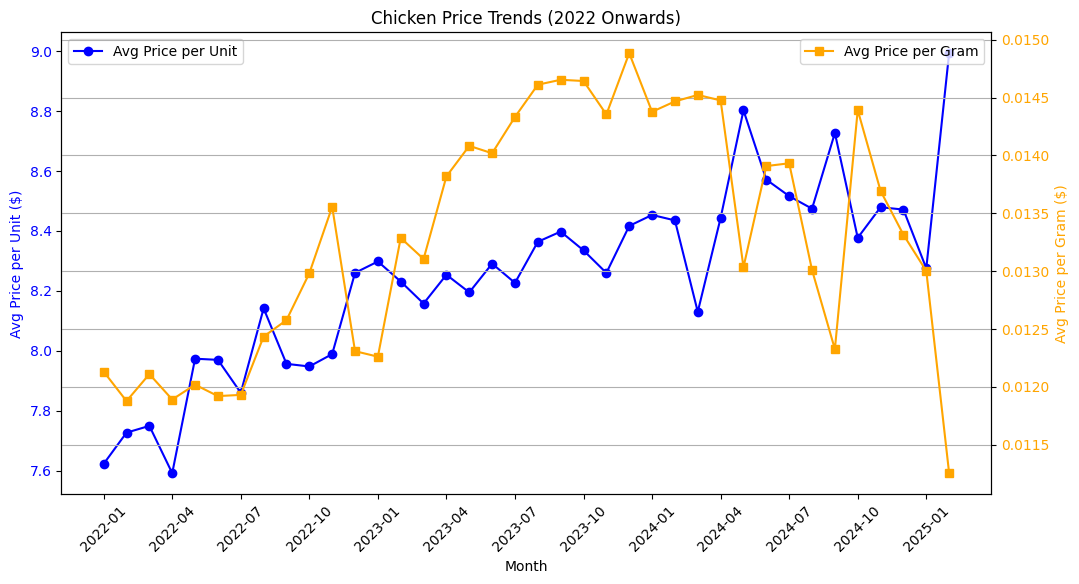

In [72]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Avg Price per Unit on primary y-axis
ax1.plot(monthly_price_trend['year_month'], 
         monthly_price_trend['current_price_ea'], 
         marker='o', color='b', label='Avg Price per Unit')

# Set labels for primary y-axis
ax1.set_xlabel('Month')
ax1.set_ylabel('Avg Price per Unit ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create secondary y-axis for Avg Price per Gram
ax2 = ax1.twinx()
ax2.plot(monthly_price_trend['year_month'], 
         monthly_price_trend['price_per_gram'], 
         marker='s', color='orange', label='Avg Price per Gram')

# Set labels for secondary y-axis
ax2.set_ylabel('Avg Price per Gram ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and formatting
plt.title('Chicken Price Trends (2022 Onwards)')
ax1.set_xticks(range(0, len(monthly_price_trend['year_month']), 3))  # Show every 3rd month for readability
ax1.set_xticklabels(monthly_price_trend['year_month'][::3], rotation=45)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid()
plt.show()


In [88]:
# Convert `edited_at` to datetime
df['edited_at'] = pd.to_datetime(df['edited_at'])

# Create a `year_month` column
df['year_month'] = df['edited_at'].dt.to_period('M')

# Filter for post-COVID data (2022 onwards)
df = df[df['edited_at'] >= '2022-01-01']

# Filter for post-COVID data (2022 onwards)
df = df[df['edited_at'] >= '2022-01-01']

# Aggregate price trends by month, banner (grocery chain), and province
monthly_trends = df.groupby(['year_month', 'banner', 'province']).agg({
    'current_price_ea': 'mean',
    'price_per_gram': 'mean'
}).reset_index()

# Convert period to string for visualization
monthly_trends['year_month'] = monthly_trends['year_month'].astype(str)


### Time-Series Forecasting -   ARIMA or Prophet to predict future price trends.



#### Price Trends Across Grocery Chains

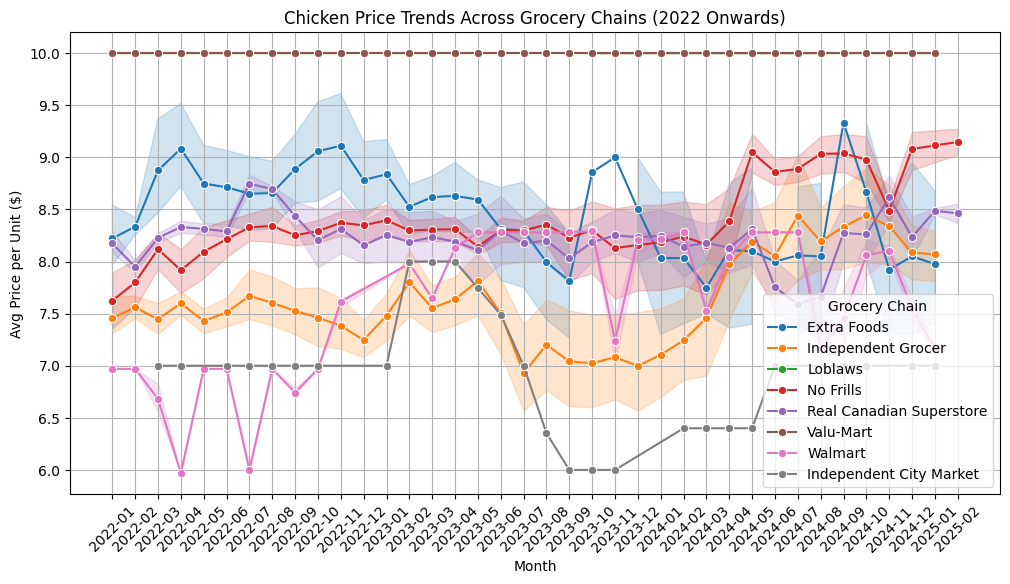

In [91]:
# Plot trends across grocery chains
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x="year_month", y="current_price_ea", hue="banner", marker="o")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Avg Price per Unit ($)")
plt.title("Chicken Price Trends Across Grocery Chains (2022 Onwards)")
plt.legend(title="Grocery Chain")
plt.grid()

plt.show()

####  Regional Price Variations

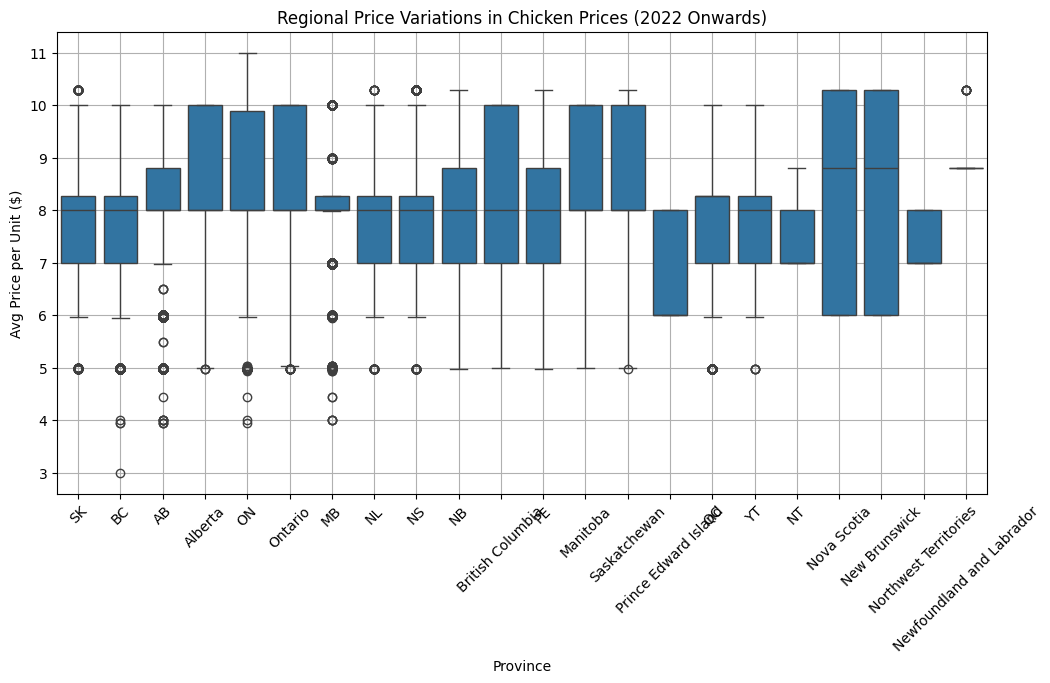

In [92]:
# Box Plot of Chicken Prices Across Provinces
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="province", y="current_price_ea")
plt.xticks(rotation=45)
plt.xlabel("Province")
plt.ylabel("Avg Price per Unit ($)")
plt.title("Regional Price Variations in Chicken Prices (2022 Onwards)")
plt.grid()
plt.show()


#### Forecasting Chicken Prices (ARIMA Model)

In [93]:
from statsmodels.tsa.arima.model import ARIMA

/Users/shivamverma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/shivamverma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/shivamverma/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/var/folders/0h/mz4ht1jx3db5k740465q827h0000gn/T/ipykernel_20898/212997104.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=monthly_forecast.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', linestyle="dashed")


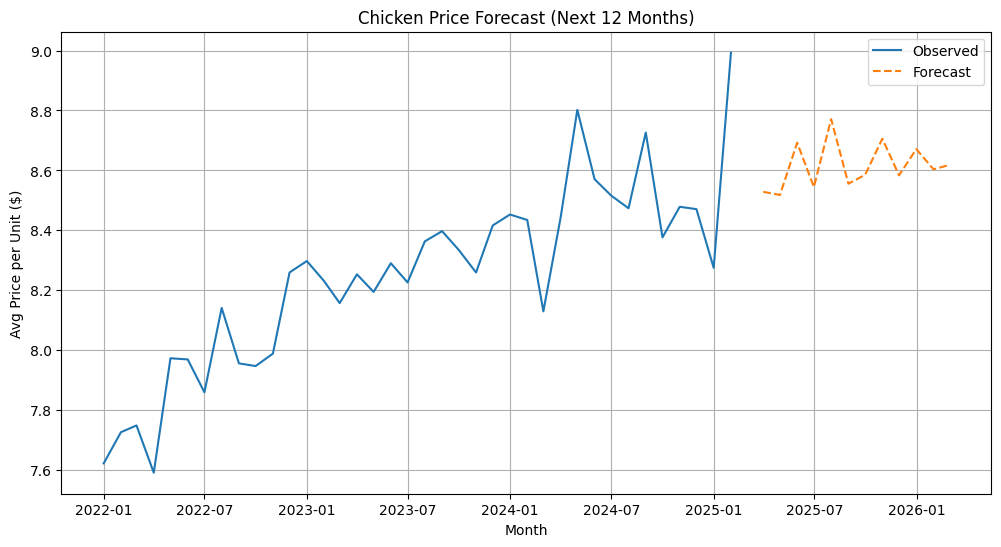

In [96]:
# Aggregate price by month for forecasting
monthly_forecast = df.groupby("year_month")['current_price_ea'].mean().reset_index()
monthly_forecast['year_month'] = monthly_forecast['year_month'].astype(str)

# Convert to datetime index
monthly_forecast.set_index('year_month', inplace=True)
monthly_forecast.index = pd.to_datetime(monthly_forecast.index)

# Train ARIMA model
model = ARIMA(monthly_forecast['current_price_ea'], order=(5,1,0))  # Adjust order based on ACF/PACF
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_forecast.index, monthly_forecast['current_price_ea'], label='Observed')
plt.plot(pd.date_range(start=monthly_forecast.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', linestyle="dashed")
plt.xlabel("Month")
plt.ylabel("Avg Price per Unit ($)")
plt.title("Chicken Price Forecast (Next 12 Months)")
plt.legend()
plt.grid()
plt.show()